In [327]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
mpl.rcParams['figure.dpi'] = 175
h = 6.6260755e-27 # Planck's constant [erg] [s]
q = 4.803e-10 # electron charge
m_e = 9.109e-28
m_p = 1.6726e-24
c = 2.998e10
h = 6.626e-27

def power_law(gamma, power, A):
    return A * gamma ** (power)

def eV_e(gamma):
    return (gamma*m_e*c**2) / 1.602e-12

def eV_eps(eps):
    return m_e * c**2 * eps / 1.602e-12

def nu_eps(eps):
    return m_e * c**2 * eps / h

def gamma_e(eV):
    return eV / 511000

def eV_p(freq):
    return 4.1357e-13*freq

def make_odd(num):
    if (num % 2 == 0):
        return num + 1
    else:
        return num

In [122]:
def power_law(gamma, power, A):
    return A * gamma ** (power)

# Define the exponential function
def exp_func(gamma, A, b):
    return A * np.exp(b * gamma)


# Function to fit the power law to data
def fit_power_law(gamma_data, y_data):
    # Initial guess for the parameters
    initial_guess = [-1., 1.]
    
    # Fit the curve
    params, params_covariance = curve_fit(power_law, gamma_data, y_data, p0=initial_guess, maxfev=int(1e6))
    
    # Extract the fitted parameters
    fitted_power = params[0]
    fitted_A = params[1]
    
    return fitted_power, fitted_A, params_covariance
def fit_and_plot(x_data, y_data, model="exponential", plot_result=False):
    """
    Fits a model to 2D data and optionally plots the result.

    Parameters:
        x_data (array-like): The x-coordinates of the data.
        y_data (array-like): The y-coordinates of the data.
        model (str): Model to fit ("exponential", "generalized", "power_law").
        plot_result (bool): If True, plots the fitted curve against the data.

    Returns:
        popt (tuple): Optimized parameters for the model.
        pcov (2D array): Covariance matrix of the optimized parameters.
    """
    
    # Define models
    def exponential_model(x, a, b):
        return a * np.exp(b * x)
    
    def generalized_model(x, a, b, c):
        return a * np.exp(b * x) + c
    
    def power_law_model(x, a, b):
        return a * x**b

    # Choose model
    if model == "exponential":
        fit_func = exponential_model
        p0 = [1, 0.1]  # Initial guess
    elif model == "generalized":
        fit_func = generalized_model
        p0 = [1, 0.1, 0]  # Initial guess
    elif model == "power_law":
        fit_func = power_law_model
        p0 = [1, -1]  # Initial guess
    else:
        raise ValueError("Unsupported model. Choose 'exponential', 'generalized', or 'power_law'.")

    # Perform curve fitting
    popt, pcov = curve_fit(fit_func, x_data, y_data, p0=p0, maxfev=10000)
    print(popt)
    # Plot the result if requested
    if plot_result:
        x_fit = np.linspace(min(x_data), max(x_data), 500)
        y_fit = fit_func(x_fit, *popt)
        plt.plot(x_fit, y_fit)

    
    return popt, pcov
def find_powerlaw_transition(x, y, window_length=15, poly_order=2):
    """
    Find the transition point between two power laws in log-log space.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (e.g., gamma values)
    y : array-like
        y-coordinates (e.g., particle distribution)
    window_length : int, optional
        Window length for Savitzky-Golay filter (must be odd)
    poly_order : int, optional
        Polynomial order for the smoothing filter
        
    Returns:
    --------
    transition_point : float
        x-value where the power law transition occurs
    slopes : tuple
        (slope before transition, slope after transition)
    """
    # Convert to log space
    log_x = np.log10(x)
    log_y = np.log10(y)
    
    # Compute numerical derivative (gradient)
    # First smooth the data to reduce noise
    smooth_log_y = savgol_filter(log_y, window_length, poly_order)
    
    # Calculate gradient using central differences
    gradient = np.gradient(smooth_log_y, log_x)
    
    # Smooth the gradient
    smooth_gradient = savgol_filter(gradient, window_length, poly_order)
    
    # Find where gradient changes most rapidly (second derivative peaks)
    second_derivative = np.abs(np.gradient(smooth_gradient, log_x))
    
    # Find the peak in second derivative
    # Exclude edges to avoid boundary effects
    margin = window_length
    peak_idx = margin + np.argmax(second_derivative[margin:-margin])
    
    # Fit power laws to both regions to get precise slopes
    def power_law(x, alpha, c):
        return c + alpha * x
    
    # Split data at the identified transition point
    split_idx = peak_idx
    
    # Fit before transition
    popt1, _ = curve_fit(power_law, log_x[:split_idx], log_y[:split_idx])
    # Fit after transition
    popt2, _ = curve_fit(power_law, log_x[split_idx:], log_y[split_idx:])
    
    return peak_idx, (popt1[0], popt2[0])

def fit_4th_order(x, y, zorder=0):
    # Fit a 4th order polynomial to the data
    coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
    poly = np.poly1d(coefficients)
    print(np.poly1d(coefficients))
    # Calculate fitted values and errors
    x_fit = np.linspace(min(x), max(x), 100)
    log_y_fit = poly(np.log10(x_fit))
    y_fit = 10**log_y_fit
    # Calculate errors (simplified estimate)
    residuals = np.log10(y) - poly(np.log10(x))
    std_dev = np.std(residuals)
    error_margin = std_dev
    y_fit_lower = 10**(log_y_fit - error_margin)
    y_fit_upper = 10**(log_y_fit + error_margin)
    # Plot the fit and error bands
    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.5, label="4th order polynomial fit", zorder=zorder)


# IMPLICIT STEP

In [150]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
def create_animated_plot(csv_path, column_prefix='n_e t='):
    """
    Create an animated plot from a CSV file with log-scaled axes, showing both
    theoretical predictions and measured data
    """
    # Setup paths and read data
    run_path = ""
    for folder in csv_path.split(r"\ "[0])[:-1]:
        run_path += folder + r"\ "[0]
    run_path += "runs" + r"\run_" + csv_path.split(r"\ "[0])[-1]
    df = pd.read_csv(csv_path)
    run_df = pd.read_csv(run_path)
    
    # Find time columns
    time_columns = [col for col in df.columns if column_prefix in col]
    df_time_steps = df[time_columns]
    
    # Create figure and set up axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set labels
    plt.xlabel('$\gamma$')
    plt.ylabel('$n_e$')
    
    # Create vertical lines once
    gamma_c = 1/(run_df["S"][0] * run_df["tau_esc"][0] * (1 - run_df["inject_p"][0]))
    plt.vlines([run_df["inject_min"][0],gamma_c], 1e-32,1e-14,["grey","darkgrey"],["dashed","dashed"])
    
    # Prepare theoretical curve data
    gammas = np.logspace(1, 8, 1000)  # More points for smoother animation
    inject_index = (np.abs(gammas-run_df["inject_min"][0])).argmin()
    
    # extract relevant values
    gammas[inject_index:]
    inject_p = run_df["inject_p"][0]
    S = run_df["S"][0]
    C = run_df["Q_e0"][0] * run_df["norm"][0]
    tau = run_df["tau_esc"][0]
    lw = 5
    # Create line objects for both theoretical curves and data
    theory_line1, = ax.plot([], [], 
                           c="lightgrey", 
                           alpha=0.7, 
                           ls="-",
                           lw=lw,
                           label=f"$\propto\gamma^{{{-inject_p-1}}}$")
    
    theory_line2, = ax.plot([], [], 
                           c="dimgrey",
                           alpha=0.6, 
                           ls="-",
                           lw=lw,
                           label=f"$\propto\gamma^{{{-inject_p}}}$")
    
    data_line, = ax.plot([], [], 
                        ls='-', 
                        label=f'B = {run_df["B"][0]}')
    
    def init():
        """Initialize animation"""
        theory_line1.data([], [])
        theory_line2.set_data([], [])
        data_line.set_data([], [])
        return theory_line1, theory_line2, data_line
    
    def update(frame):
        """Update animation frame"""
        # Get current time step data
        current_data = df_time_steps.iloc[:-1, frame]
        epsilon = 1e-300

        # Update measured data
        x_data = np.array(df["gamma"][:-1])
        y_data = np.array(np.abs(current_data) + epsilon)
        data_line.set_data(x_data, y_data)

        inject_index = (np.abs(x_data-run_df["inject_min"][0])).argmin()
        x_data=x_data[inject_index:]
        y_data=y_data[inject_index:]
        
        # extract time value
        time_value = float(time_columns[frame].split('=')[1])

        # plot theoretical curves
        theory1_y = np.array(power_law(gammas, -inject_p-1, C / (S*(1-inject_p))))
        theory2_y = np.array(power_law(gammas, -inject_p, C * tau))

        if (time_value < 1e7):
            turnover_index, _ = find_powerlaw_transition(x_data, y_data, window_length=make_odd(int(len(x_data)*0.25)))
            turnover_index_theory = (np.abs(gammas-x_data[turnover_index])).argmin()
            # normalize the less steep power law to the gamma_c value
            theory2_y /= theory2_y[turnover_index_theory]
            theory2_y *= y_data[turnover_index]
            # normalize the less steep power law to the gamma_c value
            theory2_y /= theory2_y[turnover_index_theory]
            theory2_y *= y_data[turnover_index]
        else:
            turnover_index = (np.abs(x_data-gamma_c)).argmin()
            turnover_index_theory = (np.abs(gammas-gamma_c)).argmin()
        
        theory_line1.set_data(gammas, theory1_y)
        theory_line2.set_data(gammas, theory2_y)
        
        # Set axis limits
        ax.set_xlim(1e1, 1e8)
        ax.set_ylim(1e-28, 1e-14)
        
        plt.title(f'Implicit Solver Relaxation - Time: {time_value:.2e}')
        
        return theory_line1, theory_line2, data_line
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(time_columns),
        init_func=init,
        interval=33.33,  # ~30 fps
        blit=True
    )
    
    plt.legend()
    return anim
# Function to save the animation
def save_animation(csv_path, output_path='animated_log_plot.gif', column_prefix='n_e t='):
    """
    Save the animated plot as a GIF
    
    Parameters:
    -----------
    csv_path : str
        Path to the input CSV file
    output_path : str, optional
        Path to save the output GIF (default: 'animated_log_plot.gif')
    column_prefix : str, optional
        Prefix of the columns representing time steps
    """
    # Create and save the animation
    plt.ioff()  # Turn off interactive mode
    anim = create_animated_plot(csv_path, column_prefix)
    
    # Save the animation
    anim.save(output_path, writer='pillow')
    print(f"Animation saved to {output_path}")
    
    # Close the plot to free up memory
    plt.close()



In [151]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np

def create_animated_plot(csv_path, column_prefix='n_e t='):
    """
    Create an animated plot from a CSV file with log-scaled axes, showing both
    theoretical predictions and measured data
    """
    # Setup paths and read data
    run_path = ""
    for folder in csv_path.split(r"\ "[0])[:-1]:
        run_path += folder + r"\ "[0]
    run_path += "runs" + r"\run_" + csv_path.split(r"\ "[0])[-1]
    df = pd.read_csv(csv_path)
    run_df = pd.read_csv(run_path)
    
    # Find time columns
    time_columns = [col for col in df.columns if column_prefix in col]
    df_time_steps = df[time_columns]
    
    # Create figure and set up axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set labels
    plt.xlabel('$\gamma$')
    plt.ylabel('$n_e$')

    data_line, = ax.plot([], [], 
                        ls='-', 
                        label=f'B = {run_df["B"][0]}')
    
    def init():
        """Initialize animation"""
        data_line.set_data([], [])
        return data_line,
    
    def update(frame):
        """Update animation frame"""
        # Get current time step data
        current_data = df_time_steps.iloc[:-1, frame]
        epsilon = 1e-300

        # Update measured data
        x_data = np.array(df["gamma"][:-1])
        y_data = np.array(np.abs(current_data) + epsilon)
        data_line.set_data(x_data, y_data)

        inject_index = (np.abs(x_data - run_df["inject_min"][0])).argmin()
        x_data = x_data[inject_index:]
        y_data = y_data[inject_index:]
        
        # extract time value
        time_value = float(time_columns[frame].split('=')[1])
        
        # Set axis limits
        ax.set_xlim(1e1, 1e8)
        ax.set_ylim(1e-23, 1e8)
        
        plt.title(f'Implicit Solver Relaxation - Time: {time_value:.2e}')
        
        return data_line,
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(time_columns),
        init_func=init,
        interval=20*33.33/30,  # ~30 fps
        blit=True
    )
    
    plt.legend()
    return anim

# Function to save the animation
def save_animation(csv_path, output_path='animated_log_plot.gif', column_prefix='n_e t='):
    """
    Save the animated plot as a GIF
    
    Parameters:
    -----------
    csv_path : str
        Path to the input CSV file
    output_path : str, optional
        Path to save the output GIF (default: 'animated_log_plot.gif')
    column_prefix : str, optional
        Prefix of the columns representing time steps
    """
    # Create and save the animation
    plt.ioff()  # Turn off interactive mode
    anim = create_animated_plot(csv_path, column_prefix)
    
    # Save the animation
    anim.save(output_path, writer='pillow')
    print(f"Animation saved to {output_path}")
    
    # Close the plot to free up memory
    plt.close()


In [152]:
csv_path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\implicit_solve\simulation_data.csv"
save_animation(csv_path)
plt.close()

IndexError: list index out of range

1.69 4.29 10715.19 6606934.0


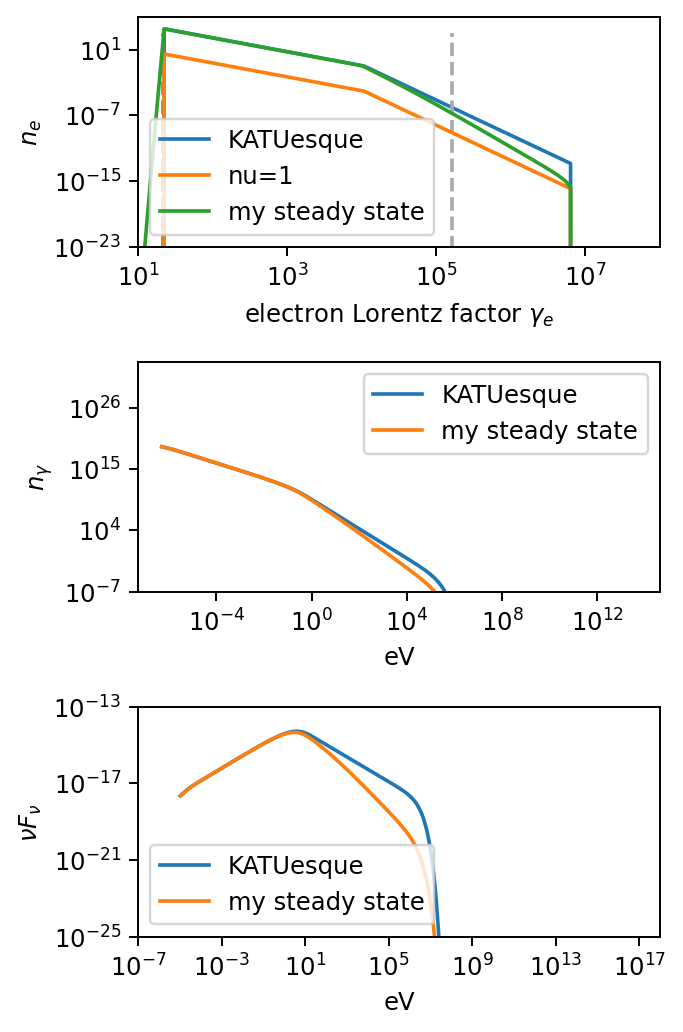

local: 1.18e+05
katu: 1.18e+05
k/l ratio 1.0011


In [361]:
# Example code
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
sim_data = pd.read_csv(path + r"\fixed_n_e.csv")
run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)

fig, axes = plt.subplots(3, 1, figsize = (4, 6))

# plot the electron population
ax = axes[0]
ax.loglog(sim_data["gamma"], sim_data["electron_n"], label = "KATUesque")
ax.set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax.set_ylabel("$n_e$")
ax.set_xlim(1e1, 1e8)
ax.set_ylim(1e-23,1e5)

Q_e0 = run_data["Q_e0"][0]
tau_esc = run_data["tau_esc"][0]
p1 = run_data["inject_p"][0]
p2 = run_data["inject_p_2"][0]
gamma_min = run_data["inject_min"][0]
gamma_max = run_data["inject_max"][0]
gamma_break = run_data["inject_break"][0]
print(p1, p2, gamma_break, gamma_max)
rho = 10 ** -21.76

A = (p1 - 1) * gamma_min ** (p1 - 1)
nu = 1
prefac = (rho / (m_e + nu * m_p)) * A 
#prefac =Q_e0 * tau_esc * A

integral = 0
integral2 = 0
n_e_steady = [0 for n in sim_data["electron_n"]]

for i in range(0, len(sim_data["electron_n"])):
    gamma = sim_data["gamma"][i]
    if gamma < gamma_break and gamma > gamma_min:
        n_e_steady[i] = gamma**-p1
    elif  gamma > gamma_break and gamma < gamma_max:
        n_e_steady[i] = (gamma_break **(p2 - p1)) * (gamma ** -p2) 
    else:
        n_e_steady[i] =  0
    n_e_steady[i] *= prefac

# Create vertical lines once
gamma_c = 1/(run_data["S"][0] * run_data["tau_esc"][0] * (1 - run_data["inject_p"][0]))
ax.vlines([run_data["inject_min"][0], gamma_c], 1e-28,1e3,["grey","darkgrey"],["dashed","dashed"])
    
ax.loglog(sim_data["gamma"], n_e_steady, label = "nu=1")

ax = axes[1]
ax.loglog(eV_eps(sim_data["photon_eps"][1:-1]), sim_data["photon_n"][1:-1], label = "KATUesque")

ax.set_xlabel("eV")
ax.set_ylabel("$n_\\gamma$")
#ax.set_xlim(1e6)
ax.set_ylim(1e-7,)
"""

# plot the resulting photon population
run_data["crit_freq"][0] = 1e-8
ax = axes[2]
freq1 = sim_data["photon_freq"][sim_data["photon_freq"] < run_data["crit_freq"][0] / 10]
freq1 = freq1[sim_data["photon_freq"] > 1e-12]
n1 = sim_data["photon_n"][sim_data["photon_freq"] < run_data["crit_freq"][0] / 10]
n1 = n1[sim_data["photon_freq"] > 1e-12]
freq2 = sim_data["photon_freq"][sim_data["photon_freq"] > run_data["crit_freq"][0] * 10]
#freq2 = freq2[sim_data["photon_freq"] < 1e20]
n2 =sim_data["photon_n"][sim_data["photon_freq"] > run_data["crit_freq"][0] * 10]
#n2 = n2[sim_data["photon_freq"] < 1e20]
p1, A1, param = fit_power_law(freq1, n1)
p2, A2, param2 = fit_power_law(freq2, n2)
print(p1, A1)
print(p2, A2)
ax.loglog((sim_data["photon_freq"][1:-1]), sim_data["photon_n"][1:-1])
ax.plot(freq1,power_law(freq1, p1, A1),label=f"p={round(p1,5)} fit")
ax.plot(freq2,power_law(freq2, p2, A2),label=f"p={round(p2,5)} fit")

ax.legend()
ax.set_xlabel(r"comoving photon frequency (Hz)")
ax.set_ylabel("$n_\\gamma$")
#ax.set_xlim(1e6, 1e27)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-45)

# j_nu plot
ax = axes[1]
ax.loglog(nu_eps(sim_data["photon_freq"][1:-1]), sim_data["j_nu"][1:-1])
ax.set_xlabel(r"comoving photon frequency (Hz)")
ax.set_ylabel("$j_{\\nu}$")
ax.set_ylim(1e-40, 1e-31)
ax.set_xlim(1e8, 1e16)
#ax.vlines([5e8, 5e14], 1e-42, 1e-12, "k","dashed", lw=1)
"""



ax = axes[2]
ax.loglog(eV_eps(sim_data["flux_eps"][1:-1]), sim_data["nu_flux"][1:-1], label = "KATUesque")
katuesque = sim_data["electron_n"]

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
sim_data = pd.read_csv(path + r"\simulation_data.csv")
run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)
my_steady_state = sim_data["electron_n"]
ax.loglog(eV_eps(sim_data["flux_eps"][1:-1]), sim_data["nu_flux"][1:-1], label="my steady state")
axes[1].loglog(eV_eps(sim_data["photon_eps"][1:-1]), sim_data["photon_n"][1:-1], label="my steady state")
axes[0].loglog((sim_data["gamma"][1:-1]), sim_data["electron_n"][1:-1], label="my steady state")
axes[0].legend()
axes[1].legend()
axes[2].legend()
ax.set_xlabel(r"eV")
ax.set_ylabel("$\\nu F_{\\nu}$")
ax.set_xlim(1e-7, 1e18)
ax.set_yscale("log")
ax.set_ylim(1e-25,1e-13)
# show
plt.tight_layout()
plt.draw()
plt.show()

for i in range(0, len(my_steady_state)-1):
    integral += 0.5 * (my_steady_state[i+1] + my_steady_state[i]) * (sim_data["gamma"][i+1] - sim_data["gamma"][i])
    integral2 += 0.5 * (katuesque[i+1] + katuesque[i]) * (sim_data["gamma"][i+1] - sim_data["gamma"][i])

print("local: %.2e" % integral)
print("katu: %.2e" % integral2)
print("k/l ratio", round((integral2 / integral),4))

L= 45 k/l ratio 4.44e+00

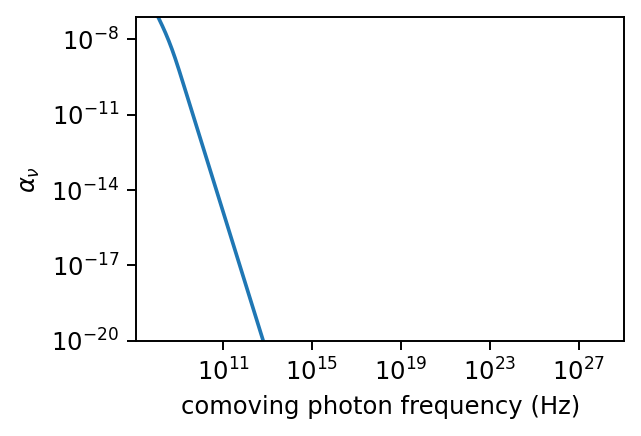

In [ ]:
sim_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\simulation_data.csv")
run_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_simulation_data.csv",index_col=False)

plt.figure(figsize=[3*1.2,2*1.2])
plt.plot(nu_eps(sim_data["photon_eps"][1:-1]), sim_data["alpha_nu"][1:-1])
plt.xlabel(r"comoving photon frequency (Hz)")
plt.ylabel("$\\alpha_{\\nu}$")
plt.ylim(1e-20,)
plt.xscale("log")
plt.yscale("log")
#plt.xlim(2e7, 1e16)
plt.show()

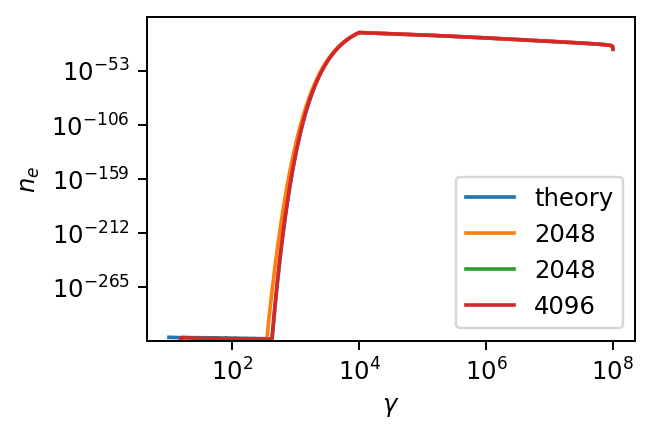

In [160]:
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\implicit_solve"
sim_data = pd.read_csv(path + r"\simulation_data.csv")
run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv",index_col=False)
plt.figure(figsize=[3*1.2,2*1.2])
#plt.plot(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="implicit")
#plt.plot(sim_data["gamma"][1:-1], sim_data["theory"][1:-1], label="theory")

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
sim_data = pd.read_csv(path + r"\best_value.csv")
plt.plot(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="theory")

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\time_testing\steady_state"
sim_data = pd.read_csv(path + r"\1_samples_per_dec_2048.csv")
plt.plot(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="2048")
plt.plot(sim_data["gamma"][1:-1], sim_data["theory"][1:-1], label="2048")

sim_data = pd.read_csv(path + r"\1_samples_per_dec_46340.csv")
plt.plot(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="4096")
#plt.plot(sim_data["gamma"][1:-1], sim_data["theory"][1:-1], label="4096")

#sim_data = pd.read_csv(path + r"\1_samples_per_dec_4096.csv")
#plt.plot(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="4096")

plt.legend()
plt.xlabel("$\\gamma$")
plt.ylabel("$n_{e}$")
#plt.ylim(1e-28)
plt.xscale("log")
plt.yscale("log")
#plt.xlim(1e1, 1e8)
plt.show()

B = 0.1


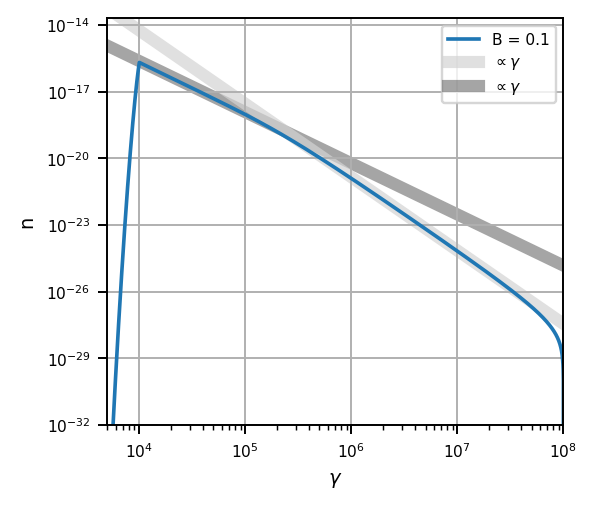

In [155]:
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\implicit_solve"
files = ["simulation_data.csv"]
names = ["B = 0.1"]
colours = ["tab:blue"]

fs=8
lw = 5
plt.figure(figsize=[3.5,3])
for file, name, colour in zip(files, names, colours): 
    sim_data=pd.read_csv(path + r"\{}".format(file))
    run_data = pd.read_csv(path + r"\runs\run_{}".format(file))
    plt.plot(sim_data["gamma"], sim_data["electron_n"], label=name, c=colour)
    print(name)
plt.plot(sim_data["gamma"], 
         power_law(np.array(sim_data["gamma"]), -run_data["inject_p"][0]-1, run_data["C"][0] / (run_data["S"][0]*(1-run_data["inject_p"][0]))), 
         c= "lightgrey", 
         alpha=0.7, 
         ls="-",
         lw=lw,
         label="$\propto\gamma^{{}}$".format(-run_data["inject_p"][0]-1),
         zorder=1,
)
plt.plot(sim_data["gamma"], 
         power_law(np.array(sim_data["gamma"]), -run_data["inject_p"][0], run_data["C"][0] * run_data["tau_esc"][0]), 
         c = "dimgrey",
         alpha=0.6, 
         ls="-",
         lw=lw,
         label="$\propto\gamma^{{}}$".format(-run_data["inject_p"]),
         zorder=0,
)
plt.ylabel("n", fontsize=fs)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\gamma$", fontsize=fs)
plt.xticks(fontsize=fs*0.8)
plt.yticks(fontsize=fs*0.8)
plt.legend( loc="upper right",fontsize=fs*0.8)
plt.xlim(5e3, 1e8)
plt.ylim(1e-32, 2e-14)
#plt.vlines(run_data["gamma_crit"][0], 1e-32, 2e12, "black", "dashed",lw=1)
plt.tight_layout()
plt.grid()

# Comparing to KATU

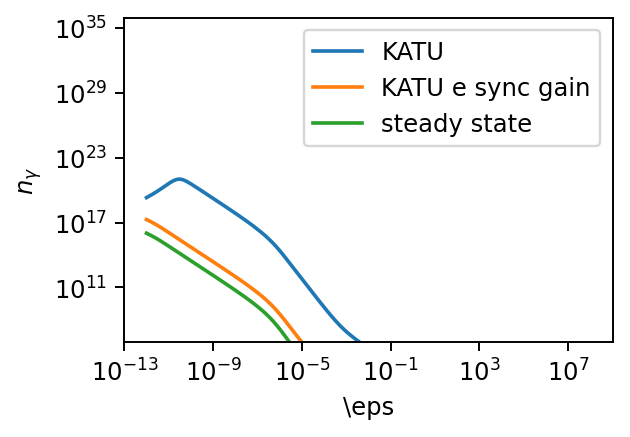

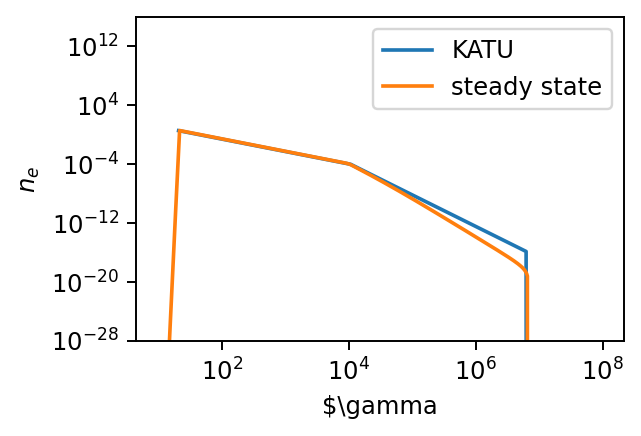

local: 1.11e+02
katu: 1.04e+02
k/l ratio 0.9338


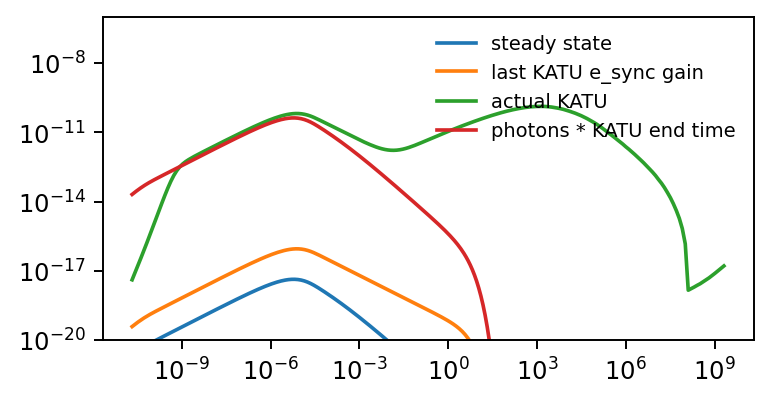

In [490]:
iter = "0016"
time = 9.69263e+06
plt.figure(figsize=[3*1.2,2*1.2])
path = r"\\wsl$\Ubuntu\home\morgan\katu\data"
katu_photon_data = pd.read_csv(path + r"\photon_data_{}.tsv".format(iter), sep="\t", skiprows=1)
katu_electron_data = pd.read_csv(path + r"\lepton_data_{}.tsv".format(iter), sep="\t", skiprows=2)
katu_photon_data.rename(columns=lambda x: x.lstrip('#').strip(), inplace=True)
katu_electron_data.rename(columns=lambda x: x.lstrip('#').strip(), inplace=True)

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
sim_data = pd.read_csv(path + r"\simulation_data.csv")
run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)

plt.loglog(katu_photon_data["Energy"],katu_photon_data["Population"], label="KATU")
plt.loglog(katu_photon_data["Energy"],katu_photon_data["e_sync_gains"], label="KATU e sync gain")
plt.loglog(sim_data["photon_eps"][1:-1], sim_data["photon_n"][1:-1], label="steady state")

plt.legend()
plt.xlabel("\\eps")
plt.ylabel("$n_\\gamma$")
#plt.set_xlim(1e6)
plt.ylim(1e6,)
plt.show()

plt.figure(figsize=[3*1.2,2*1.2])
plt.loglog(katu_electron_data["Energy"], katu_electron_data["Population"], label="KATU")
#run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)
plt.loglog(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="steady state")

plt.legend()
plt.xlabel("$\\gamma")
plt.ylabel("$n_e$")
#plt.set_xlim(1e6)
plt.ylim(1e-28,)
plt.show()

def calc_flux(run_data, Photon_eps, Photon_n):
    # Constants
    Photon_eps = np.array(Photon_eps)
    Photon_n = np.array(Photon_n)
    nu_flux = np.zeros_like(Photon_eps, dtype=np.float64)
    flux_eps = np.zeros_like(Photon_eps, dtype=np.float64)

    c = 3.0e10  # Speed of light in cm/s
    H0 = 2.27e-18  # Hubble constant in cgs
    m_e = 9.109e-28  # Electron mass in grams
    M_PI = np.pi  # Value of pi
    
    # Calculate the luminosity distance from z << 1 approximation
    dL = c * run_data["z"][0] / H0
    V = 4 / 3 * np.pi * run_data["R"][0] ** 3
    # Pre-factor calculation
    pre_fac = (
        m_e * c**2.0 * run_data["doppler_factor"][0]**4.0 * V /
        (4.0 * M_PI * (1.0 + run_data["z"][0]) * dL**2.0 * run_data["tau_esc"][0])
    )
    
    # Iterate over the array of intrinsic frequencies
    for i in range(0, len(Photon_eps)):
        # Calculate observed frequency for each intrinsic frequency
        eps_obs = run_data["doppler_factor"][0] * Photon_eps[i] / (1.0 + run_data["z"][0])
        # Calculate the flux in the observer frame
        nu_flux[i] = pre_fac * (Photon_eps[i]**2 * Photon_n[i])
        flux_eps[i] = eps_obs
    return flux_eps, nu_flux

integral = 0
integral2 = 0

for i in range(0, len(sim_data["electron_n"])-1):
    integral += 0.5 * (sim_data["electron_n"][i+1] + sim_data["electron_n"][i]) * (sim_data["gamma"][i+1] - sim_data["gamma"][i])

for i in range(0, len(katu_electron_data["Energy"])-1):
    integral2 += 0.5 * (katu_electron_data["Population"][i+1] + katu_electron_data["Population"][i]) * (katu_electron_data["Energy"][i+1] - katu_electron_data["Energy"][i])

print("local: %.2e" % integral)
print("katu: %.2e" % integral2)
print("k/l ratio", round((integral2 / integral),4))

plt.figure(figsize=[4*1.2,2*1.2])
plt.loglog(sim_data["flux_eps"][1:-1], sim_data["nu_flux"][1:-1], label="steady state")
flux_eps, nu_flux = calc_flux(run_data, katu_photon_data["Energy"], katu_photon_data["e_sync_gains"])
plt.loglog(flux_eps, nu_flux, label="last KATU e_sync gain")
flux_eps, nu_flux = calc_flux(run_data, katu_photon_data["Energy"], katu_photon_data["Population"])
plt.loglog(flux_eps, nu_flux, label = "actual KATU")

plt.loglog(sim_data["flux_eps"][1:-1], sim_data["nu_flux"][1:-1]*time, label="photons * KATU end time")
plt.legend(fontsize = 8, frameon=False, loc="upper right")
plt.ylim(1e-20,1e-6)
plt.show()

In [ ]:
def R(x):
    if x < 1:
        return 1.80842 * x**(1.0 / 3.0)
    else:
        return (np.pi / 2) * np.exp(-x) * (1 - (99.0 / (162.0 * x)))

def calc_flux(run_data, Photon_eps, Photon_n, Electron_gamma, Electron_n):
    # Constants
    Photon_eps = np.array(Photon_eps)
    Photon_n = np.array(Photon_n)
    Electron_gamma = np.array(Electron_gamma)
    Electron_n = np.array(Electron_n)
    nu_flux = np.zeros_like(Photon_eps, dtype=np.float64)
    flux_eps = np.zeros_like(Photon_eps, dtype=np.float64)

    c = 3.0e10  # Speed of light in cm/s
    H0 = 2.27e-18  # Hubble constant in cgs
    m_e = 9.109e-28  # Electron mass in grams
    q = 4.8032e-10  # Elementary charge in esu
    h = 6.626e-27  # Planck's constant in erg*sec
    
    # Calculate the luminosity distance from z << 1 approximation
    dL = c * run_data["z"][0] / H0
    
    # Pre-factor calculation
    pre_fac = (np.sqrt(3) * run_data["doppler_factor"][0]**4 * q**3 * run_data["B"][0]) / (4.0 * np.pi * h * dL**2)
    x_pre_fac = (4.0 * np.pi * m_e**2 * c**3) / (3.0 * q * run_data["B"][0] * h)
    
    # Iterate over the array of intrinsic frequencies
    for i in range(len(Photon_eps)):
        # Calculate observed frequency for each intrinsic frequency
        eps_obs = run_data["doppler_factor"][0] * Photon_eps[i] / (1.0 + run_data["z"][0])
        integral = 0
        # Calculate the flux in the observer frame
        for j in range(len(Electron_gamma) - 1):
            x0 = x_pre_fac * Photon_eps[i] / Electron_gamma[j]**2
            x1 = x_pre_fac * Photon_eps[i] / Electron_gamma[j + 1]**2
            integral += 0.5 * (Electron_n[j + 1] * R(x1) + Electron_n[j] * R(x0)) * (Electron_gamma[j + 1] - Electron_gamma[j])
        nu_flux[i] = pre_fac * Photon_eps[i] * integral
        flux_eps[i] = eps_obs
    
    return flux_eps, nu_flux

flux_eps, nu_flux = calc_flux(run_data,sim_data["photon_eps"],sim_data["photon_n"],sim_data["gamma"],sim_data["electron_n"])


In [103]:
spds = [2**(n/2) for n in range(8,32)]
print(spds)

[16.0, 22.627416997969522, 32.0, 45.254833995939045, 64.0, 90.50966799187809, 128.0, 181.01933598375618, 256.0, 362.03867196751236, 512.0, 724.0773439350247, 1024.0, 1448.1546878700494, 2048.0, 2896.309375740099, 4096.0, 5792.618751480198, 8192.0, 11585.237502960395, 16384.0, 23170.47500592079, 32768.0, 46340.95001184158]


In [217]:
spds = [int(2**(n/2)) for n in range(8,25)]
files = [f"samples_per_dec_{spd}.csv" for spd in spds]
steady_state_spd=[]
steady_state_time=[]
implicit_spd=[]
implicit_time=[]
temp=0
temp2=0
column = "stepping_t"
tests =25

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\time_testing"
for mainfile, name in zip(files,spds): 
    for iter in range(1,tests+1):
        file = f"{iter}_" + mainfile
        run_data=pd.read_csv(path + r"\steady_state\runs\run_{}".format(file))
        temp += run_data[column][0]
        run_data2=pd.read_csv(path + r"\implicit_solve\runs\run_{}".format(file))
        temp2 += run_data2[column][0]
    steady_state_spd.append(run_data["samples_per_decade"][0])
    implicit_spd.append(run_data2["samples_per_decade"][0])
    steady_state_time.append(temp / tests)
    implicit_time.append(temp2 / tests)

steady_state_spd=np.array(steady_state_spd[:])
steady_state_time=np.array(steady_state_time[:])
implicit_err=np.array(implicit_spd[:])
implicit_time=np.array(implicit_time[:])

[1.23939030e-05 8.11000735e-01]
[4.12060001e-05 9.23432412e-01]


C:\Users\morga\AppData\Local\Temp\ipykernel_5584\2823782749.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,)


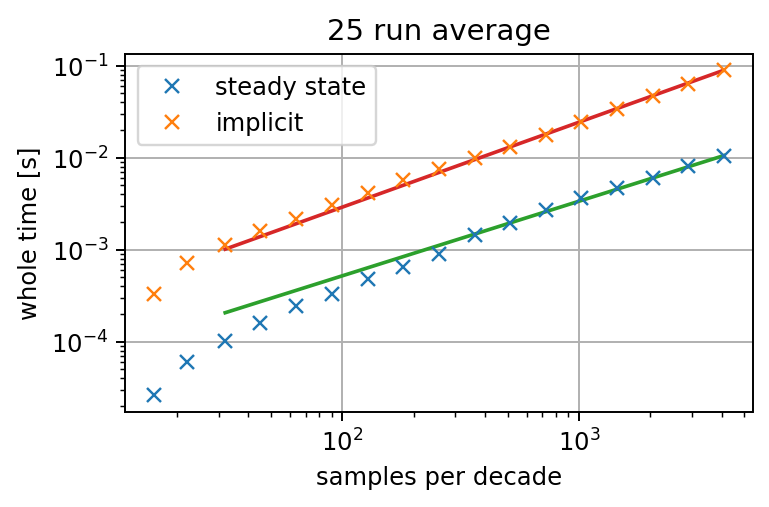

In [219]:
plt.figure(figsize=[4.5,3])
plt.plot(steady_state_spd, steady_state_time, "x", label="steady state", zorder=3)
plt.plot(implicit_spd, implicit_time, "x",label = "implicit", zorder=3)
fit_and_plot(steady_state_spd[2:], steady_state_time[2:], "power_law", True)
fit_and_plot(implicit_spd[2:], implicit_time[2:], "power_law", True)
plt.ylabel(f"whole time [s]")
if column == "whole_t":
    plt.ylabel(f"Sim time (inc writing) [s]")
plt.yscale("log")
plt.xscale("log")
plt.title(f"{tests} run average")
plt.xlabel("samples per decade")
plt.legend()
plt.tight_layout()
plt.grid()
plt.ylim(0,)
plt.show()

In [220]:
spds = [int(2**(n/2)) for n in range(8,32)]
files = [f"err_run_spd_{spd}.csv" for spd in spds]
steady_state_spd=[]
steady_state_err=[]
temp=0
temp2=0
column = "theory_error"
tests = 1
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\time_testing"
for mainfile, name in zip(files,spds): 
    for iter in range(1,tests+1):
        file = mainfile
        run_data=pd.read_csv(path + r"\steady_state\runs\run_{}".format(file))
        steady_state_spd.append(run_data["samples_per_decade"][0])
        steady_state_err.append(run_data[column][0])

steady_state_err=np.array(steady_state_err[:])
steady_state_spd=np.array(steady_state_spd[:])

In [221]:
steady_state_err

array([5.300543e-18, 5.077918e-18, 4.409532e-18, 3.606349e-18,
       2.781763e-18, 2.106981e-18, 1.552867e-18, 1.136148e-18,
       8.244339e-19, 5.936426e-19, 4.255398e-19, 3.033327e-19,
       2.157888e-19, 1.529995e-19, 1.080439e-19, 7.612935e-20,
       5.341784e-20, 3.733794e-20, 2.590944e-20, 1.786697e-20,
       1.210564e-20, 8.165546e-21, 5.191190e-21, 3.441887e-21])

C:\Users\morga\AppData\Local\Temp\ipykernel_5584\2022430007.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,)


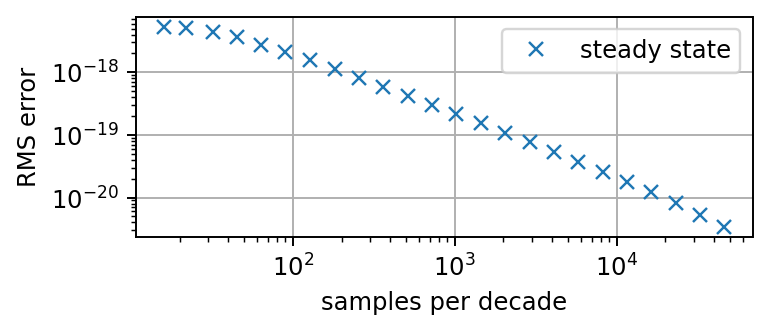

In [222]:
plt.figure(figsize=[4.5,2])
plt.plot(steady_state_spd, steady_state_err, "x", label="steady state", zorder=3)
#fit_and_plot(steady_state_spd[:], steady_state_err[:], "power_law", True)
plt.ylabel(f"RMS error")
if column == "whole_t":
    plt.ylabel(f"Sim time (inc writing) [s]")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("samples per decade")
plt.legend()
plt.tight_layout()
plt.grid()
plt.ylim(0,)
plt.show()

[0.00988268 0.08897317]


C:\Users\morga\AppData\Local\Temp\ipykernel_4272\3556792565.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,)


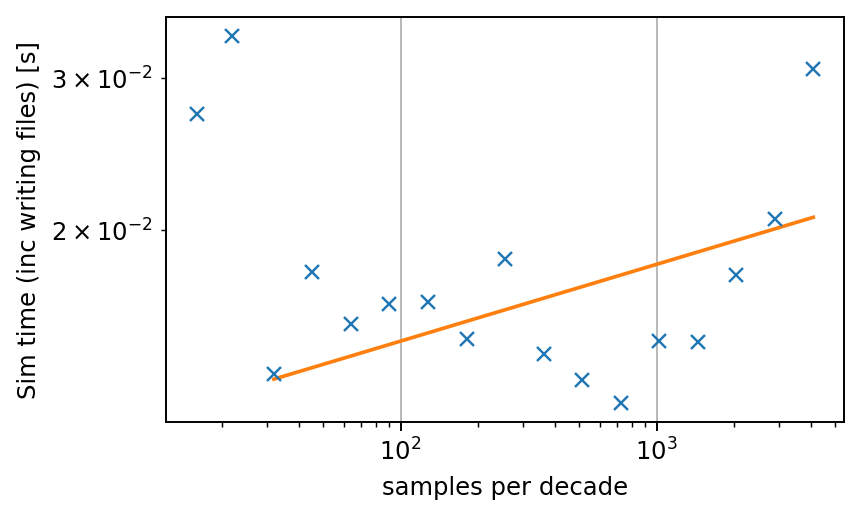

In [ ]:
spds = [2**(n/2) for n in range(8,25)]
files = [f"samples_per_dec_{int(spd)}.csv" for spd in spds]
steady_state_spd=[]
steady_state_time=[]
implicit_spd=[]
implicit_time=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,spds): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    steady_state_spd.append(run_data["samples_per_decade"][0])
    steady_state_time.append(run_data["whole_t"][0])

plt.plot(steady_state_spd, steady_state_time, "x", zorder=3)
plt.yscale("log")
plt.xscale("log")

steady_state_spd=np.array(steady_state_spd[2:])
steady_state_time=np.array(steady_state_time[2:])

# Fit a 4th order polynomial to the data
# Calculate fitted values and errors

x_fit = np.linspace(min(steady_state_spd), max(steady_state_spd), 1000)
fit_and_plot(steady_state_spd, steady_state_time, "power_law", True)

plt.ylabel(f"Sim time (inc writing files) [s]")

plt.xlabel("samples per decade")
#plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.9)
#plt.grid(which="minor", alpha=0.5)
plt.ylim(0,)
plt.show()

iter 1, t_acc 0.5, tau_esc, p_fit -1.4964362829206113, p_theory-1.5

iter 1, t_acc 1.0, tau_esc, p_fit -1.9858791918710355, p_theory-2.0

iter 1, t_acc 1.5, tau_esc, p_fit -2.468523090072164, p_theory-2.5

iter 1, t_acc 2.0, tau_esc, p_fit -2.9445542220314893, p_theory-3.0

iter 1, t_acc 4.0, tau_esc, p_fit -4.786022632772052, p_theory-4.9999992



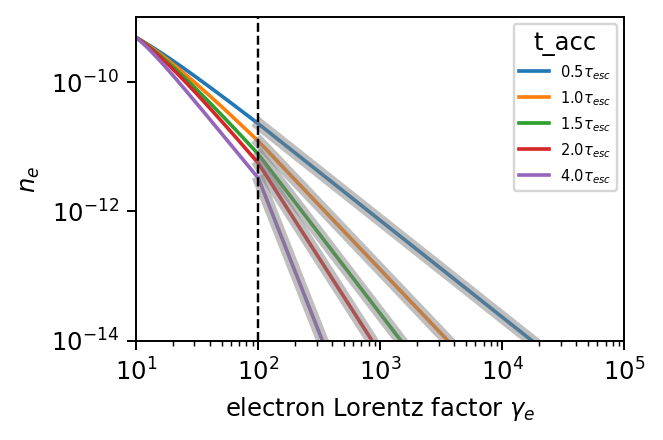

In [ ]:
t_esc_multiple = ["0.5","1.0","1.5","2.0","4.0"]
plt.figure(figsize=[3*1.2,2*1.2])
for multiple in t_esc_multiple:
    sim_data = pd.read_csv(fr"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\t_acc={multiple}_t_esc.csv")
    run_data = pd.read_csv(fr"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)

    sim_data = sim_data[sim_data["electron_n"] > 1e-20]
    plt.loglog(sim_data["gamma"], sim_data["electron_n"], label ="{}".format(round(run_data["tau_acc"][0]/run_data["tau_esc"][0], 1)) + "$\\tau_{esc}$")
    steady_state_spd = sim_data["gamma"][sim_data["gamma"] > run_data["inject_min"][0] * 10]
    steady_state_time = sim_data["electron_n"][sim_data["gamma"] > run_data["inject_min"][0] * 10]

    p, A, param = fit_power_law(steady_state_spd,steady_state_time)
    print("iter {}, t_acc {}, ".format(run_data["iter"][0],round(run_data["tau_acc"][0]/run_data["tau_esc"][0], 1)) + "tau_esc, " + "p_fit {}, p_theory{}".format(p,-round((1 + run_data["tau_acc"][0] / run_data["tau_esc"][0]),7)))
    print()
    plt.plot(steady_state_spd, power_law(steady_state_spd,p,A), "grey", alpha=0.5, lw=5,) #label = f"p = {round(p, 3)}")

plt.vlines(run_data["inject_max"][0], 1e-14, 1e-9,"black", "dashed", lw=1)
plt.legend(title = "t_acc", fontsize=6)
plt.xlabel(r"electron Lorentz factor $\gamma_e$")
plt.ylabel("$n_e$")
plt.xlim(1e1, 1e5)
plt.ylim(1e-14,1e-9)
plt.show()

0.5tau_esc, p_fit -1.2509589360297495, p_theory-1.4999999

1.0tau_esc, p_fit -1.4702986598580667, p_theory-2.0

1.5tau_esc, p_fit -1.5910871394739698, p_theory-2.4999995

2.0tau_esc, p_fit -1.6484163490260901, p_theory-3.0000003

4.0tau_esc, p_fit -1.6879751483673295, p_theory-4.9999992



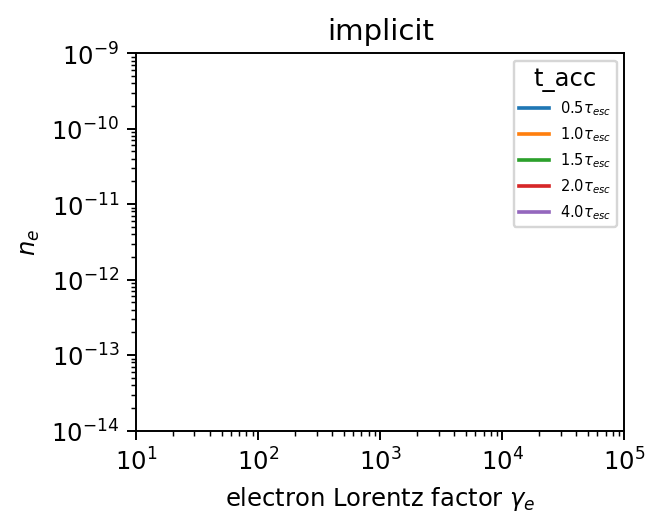

In [ ]:
t_esc_multiple = ["0.5","1.0","1.5","2.0","4.0"]
plt.figure(figsize=[3*1.2,2*1.4])
for multiple in t_esc_multiple:
    run_data = pd.read_csv(fr"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\implicit_solve\t_acc={multiple}_t_esc.csv")
    run_data = pd.read_csv(fr"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\implicit_solve\runs\run_t_acc={multiple}_t_esc.csv", index_col=False)

    run_data = run_data[run_data["electron_n"] > 1e-20]
    plt.loglog(run_data["gamma"], run_data["electron_n"], label ="{}".format(round(run_data["tau_acc"][0]/run_data["tau_esc"][0], 1)) + "$\\tau_{esc}$")
    steady_state_spd = run_data["gamma"][run_data["gamma"] > run_data["inject_min"][0] * 10]
    steady_state_time = run_data["electron_n"][run_data["gamma"] > run_data["inject_min"][0] * 10]

    p, A, param = fit_power_law(steady_state_spd,steady_state_time)
    print("{}".format(round(run_data["tau_acc"][0]/run_data["tau_esc"][0], 1)) + "tau_esc, " + "p_fit {}, p_theory{}".format(p,-round((1 + run_data["tau_acc"][0] / run_data["tau_esc"][0]),7)))
    print()
    plt.plot(steady_state_spd, power_law(steady_state_spd,p,A), "grey", alpha=0.5, lw=5,) #label = f"p = {round(p, 3)}")

plt.vlines(run_data["inject_max"][0], 1e-14, 1e-9,"black", "dashed", lw=1)
plt.legend(title = "t_acc", fontsize=6)
plt.xlabel(r"electron Lorentz factor $\gamma_e$")
plt.ylabel("$n_e$")
plt.xlim(1e1, 1e5)
plt.ylim(1e-14,1e-9)
plt.title("implicit")
plt.minorticks_on()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import os

def create_animated_plot(csv_path, column_prefix='n_e t='):
    """
    Create an animated plot from a CSV file with log-scaled axes, showing both
    theoretical predictions and measured data.
    """
    # Read data
    df = pd.read_csv(csv_path)
    
    # Debug: Print column names to verify
    print("Available columns:", list(df.columns))
    
    # Find time columns
    iter_columns = [col for col in df.columns if column_prefix in col]
    
    # Debug: Check time columns
    print("Time columns found:", iter_columns)
    
    if not iter_columns:
        raise ValueError(f"No columns found with prefix '{column_prefix}'. Check your column names.")
    
    iter_columns
    df_iter_steps = df[iter_columns]
    
    # Create figure and set up axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set labels
    plt.xlabel('$\gamma$')
    plt.ylabel('$n_e$')

    # Debug: Ensure we have data to plot
    data_line, = ax.plot([], [], ls='-', label='Data')
    
    def init():
        """Initialize animation"""
        data_line.set_data([], [])
        return data_line,
    
    def update(frame):
        """Update animation frame"""
        if frame >= len(iter_columns):
            print(f"Frame {frame} is out of range.")
            return data_line,
        
        # Get current time step data
        current_data = df_iter_steps.iloc[:, frame]
        epsilon = 1e-256

        # Update measured data
        x_data = np.array(df["gamma"])
        y_data = np.array(np.abs(current_data) + epsilon)
        
        # Debug: Print data to ensure it's not empty
        #print(f"Frame {frame}: x_data shape {x_data.shape}, y_data shape {y_data.shape}")
        
        data_line.set_data(x_data, y_data)
        
        # Extract time value
        indexes = float(iter_columns[frame].split('_')[-1]) if '_' in iter_columns[frame] else frame
        
        # Set axis limits
        ax.set_xlim(1e1, 1e5)
        ax.set_ylim(1e-14, 1e-9)
        
        plt.title(f'Steady state solver - array index: {indexes}')
        return data_line,

    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(iter_columns),
        init_func=init,
        interval=33.33/2,  # milliseconds between frames
        blit=True
    )
    
    plt.legend()
    return anim

def save_animation(csv_path, output_path='animated_log_plot.gif', column_prefix='n_e t='):
    """
    Save the animated plot as a GIF.
    """
    plt.ioff()  # Turn off interactive mode
    
    try:
        # Create and save the animation
        anim = create_animated_plot(csv_path, column_prefix)
        
        # Save the animation
        anim.save(output_path, writer='pillow', fps=30)
        print(f"Animation saved to {output_path}")
    
    except Exception as e:
        print(f"Error creating animation: {e}")
    
    finally:
        # Close the plot to free up memory
        plt.close()

# Usage example
# save_animation(r"path_to_your_csv", output_path="output.gif", column_prefix="your_prefix")

In [ ]:
csv_path = r"C:\\Users\\morga\\Masters Year\\Modelling\\Mphys_modelling\\csv_data\\steady_state\\simulation_data.csv"
save_animation(csv_path, output_path="steady_state_solve.gif", column_prefix="ne_iter_")

Available columns: ['gamma', 'ne_iter_0', 'ne_iter_1', 'ne_iter_2', 'ne_iter_3', 'ne_iter_4', 'ne_iter_5', 'ne_iter_6', 'ne_iter_7', 'ne_iter_8', 'ne_iter_9', 'ne_iter_10', 'ne_iter_11', 'ne_iter_12', 'ne_iter_13', 'ne_iter_14', 'ne_iter_15', 'ne_iter_16', 'ne_iter_17', 'ne_iter_18', 'ne_iter_19', 'ne_iter_20', 'ne_iter_21', 'ne_iter_22', 'ne_iter_23', 'ne_iter_24', 'ne_iter_25', 'ne_iter_26', 'ne_iter_27', 'ne_iter_28', 'ne_iter_29', 'ne_iter_30', 'ne_iter_31', 'ne_iter_32', 'ne_iter_33', 'ne_iter_34', 'ne_iter_35', 'ne_iter_36', 'ne_iter_37', 'ne_iter_38', 'ne_iter_39', 'ne_iter_40', 'ne_iter_41', 'ne_iter_42', 'ne_iter_43', 'ne_iter_44', 'ne_iter_45', 'ne_iter_46', 'ne_iter_47', 'ne_iter_48', 'ne_iter_49', 'ne_iter_50', 'ne_iter_51', 'ne_iter_52', 'ne_iter_53', 'ne_iter_54', 'ne_iter_55', 'ne_iter_56', 'ne_iter_57', 'ne_iter_58', 'ne_iter_59', 'ne_iter_60', 'ne_iter_61', 'ne_iter_62', 'ne_iter_63', 'ne_iter_64', 'ne_iter_65', 'ne_iter_66', 'ne_iter_67', 'ne_iter_68', 'ne_iter_69', '

In [ ]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]

# Define your model function
def model(x, a, b):
    return a * x**b

steady_state_spd=[]
steady_state_time=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\runs\run_{}".format(file))
    steady_state_spd.append(run_data["B"][0])
    steady_state_time.append(run_data["final_time"][0])
steady_state_spd=np.array(steady_state_spd)
steady_state_time=np.array(steady_state_time)
steady_state_time = steady_state_time
plt.plot(steady_state_spd, steady_state_time, "rx", zorder=3)

# Fit a 4th order polynomial to the data
coefficients = np.polyfit(np.log10(steady_state_spd), np.log10(steady_state_time), 4)
poly = np.poly1d(coefficients)
print(np.poly1d(coefficients))
# Calculate fitted values and errors
x_fit = np.linspace(min(steady_state_spd), max(steady_state_spd), 100)
log_y_fit = poly(np.log10(x_fit))
y_fit = 10**log_y_fit
# Calculate errors (simplified estimate)
residuals = np.log10(steady_state_time) - poly(np.log10(steady_state_spd))
std_dev = np.std(residuals)
error_margin = std_dev
y_fit_lower = 10**(log_y_fit - error_margin)
y_fit_upper = 10**(log_y_fit + error_margin)
# Plot the fit and error bands
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.7, label="4th order polynomial fit", zorder=2)


plt.ylabel(f"equilibrium time [tol = {run_data['end_tol'][0]}]")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("B")
plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.99)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\morga\\Masters Year\\Modelling\\Mphys_modelling\\csv_data\\runs\\run_B 100.csv'

          4           3          2
0.004314 x - 0.05191 x + 0.1728 x + 0.5146 x + 6.202


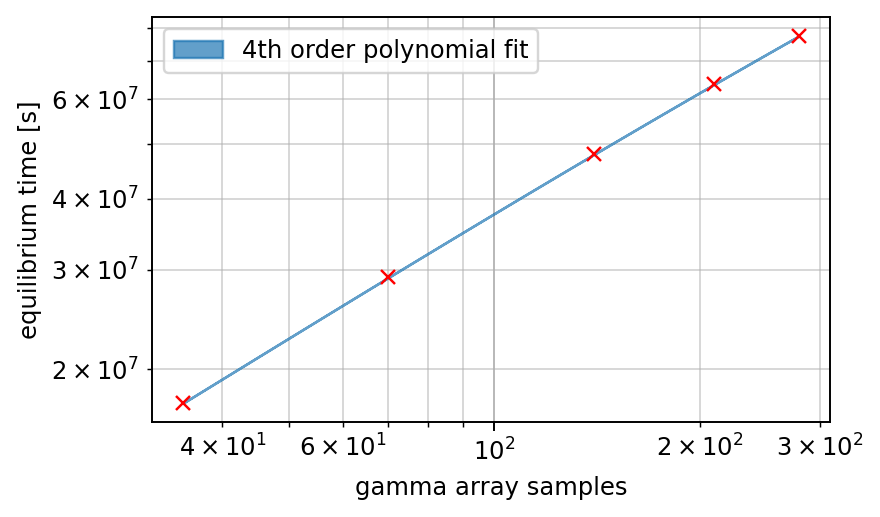

In [ ]:
files = ["samples_pd5.csv","samples_pd10.csv","samples_pd20.csv","samples_pd30.csv","samples_pd40.csv"]
names = ["spd = 5", "spd = 10", "spd = 20", "spd = 30", "spd = 40"]

# Define your model function
def model(x, a, b):
    return a * x**b

steady_state_spd=[]
steady_state_time=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\runs\run_{}".format(file))
    steady_state_spd.append(run_data["array_len"][0])
    steady_state_time.append(run_data["final_time"][0])
steady_state_spd=np.array(steady_state_spd)
steady_state_time=np.array(steady_state_time)
steady_state_time = steady_state_time
plt.plot(steady_state_spd, steady_state_time, "rx", zorder=3)

# Fit a 4th order polynomial to the data
coefficients = np.polyfit(np.log10(steady_state_spd), np.log10(steady_state_time), 4)
poly = np.poly1d(coefficients)
print(np.poly1d(coefficients))
# Calculate fitted values and errors
x_fit = np.linspace(min(steady_state_spd), max(steady_state_spd), 100)
log_y_fit = poly(np.log10(x_fit))
y_fit = 10**log_y_fit
# Calculate errors (simplified estimate)
residuals = np.log10(steady_state_time) - poly(np.log10(steady_state_spd))
std_dev = np.std(residuals)
error_margin = std_dev
y_fit_lower = 10**(log_y_fit - error_margin)
y_fit_upper = 10**(log_y_fit + error_margin)
# Plot the fit and error bands
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.7, label="4th order polynomial fit", zorder=2)


plt.ylabel(f"equilibrium time [s]")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("gamma array samples")
plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.9)
plt.grid(which="minor", alpha=0.5)

           4           3          2
-0.002829 x + 0.09736 x - 0.9045 x + 3.313 x + 2.698


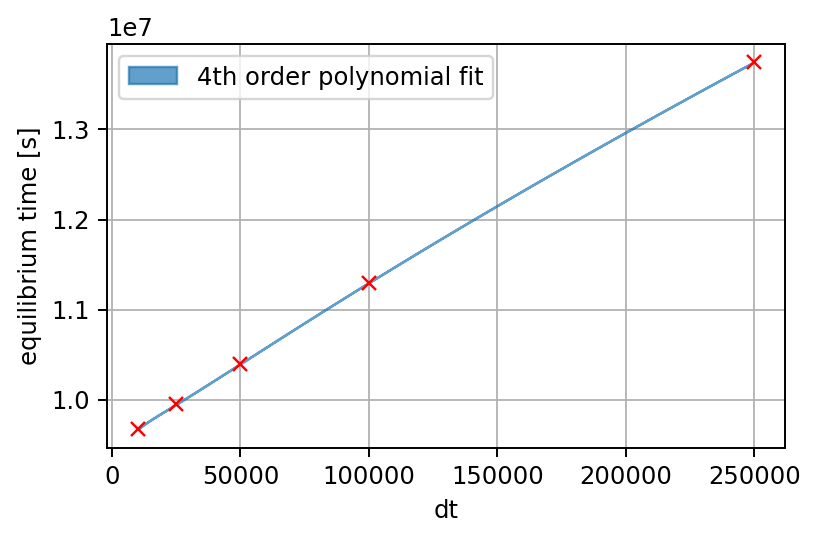

In [ ]:
dts = [10000,25000,50000,100000,250000]
files = [f"dt{dt}.csv" for dt in dts]
names = [f"dt = {dt}" for dt in dts]

# Define your model function
def model(x, a, b):
    return a * x**b

steady_state_spd=[]
steady_state_time=[]
plt.figure(figsize=[5,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\runs\run_{}".format(file))
    steady_state_spd.append(run_data["dt"][0])
    steady_state_time.append(run_data["final_time"][0])
steady_state_spd=np.array(steady_state_spd)
steady_state_time=np.array(steady_state_time)
steady_state_time = steady_state_time
plt.plot(steady_state_spd, steady_state_time, "rx", zorder=3)

# Fit a 4th order polynomial to the data
coefficients = np.polyfit(np.log10(steady_state_spd), np.log10(steady_state_time), 4)
poly = np.poly1d(coefficients)
print(np.poly1d(coefficients))
# Calculate fitted values and errors
x_fit = np.linspace(min(steady_state_spd), max(steady_state_spd), 100)
log_y_fit = poly(np.log10(x_fit))
y_fit = 10**log_y_fit
# Calculate errors (simplified estimate)
residuals = np.log10(steady_state_time) - poly(np.log10(steady_state_spd))
std_dev = np.std(residuals)
error_margin = std_dev
y_fit_lower = 10**(log_y_fit - error_margin)
y_fit_upper = 10**(log_y_fit + error_margin)
# Plot the fit and error bands
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.7, label="4th order polynomial fit", zorder=2)


plt.ylabel(f"equilibrium time [s]")
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("dt")
plt.legend()
#plt.tight_layout()
plt.grid(which="major", alpha=0.9)
plt.grid(which="minor", alpha=0.5)

ValueError: array must not contain infs or NaNs

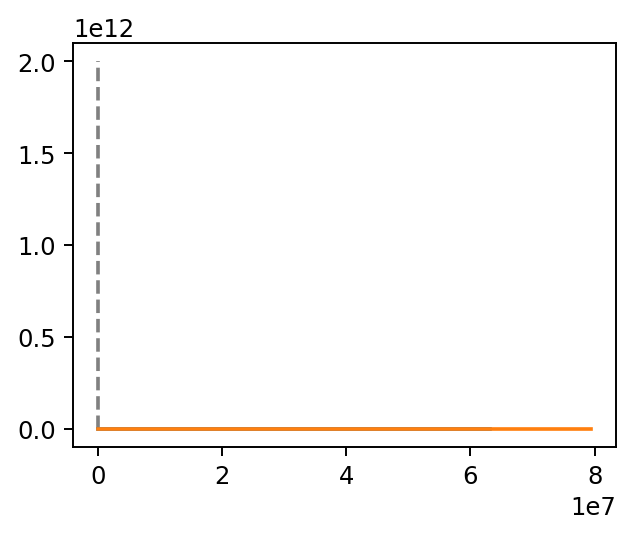

In [ ]:
# Example usage with optional fontsize
spds = [5,10,20,40,80,120]
files = [f"samples_pd{spd}.csv" for spd in spds]
names = [f"samples per dec{spd}" for spd in spds]
plot_with_fit(files, names, fontsize=12, x_range=[1e1, 1e8])

# LOG STEP

Text(0.5, 0, 'Lorentz factor')

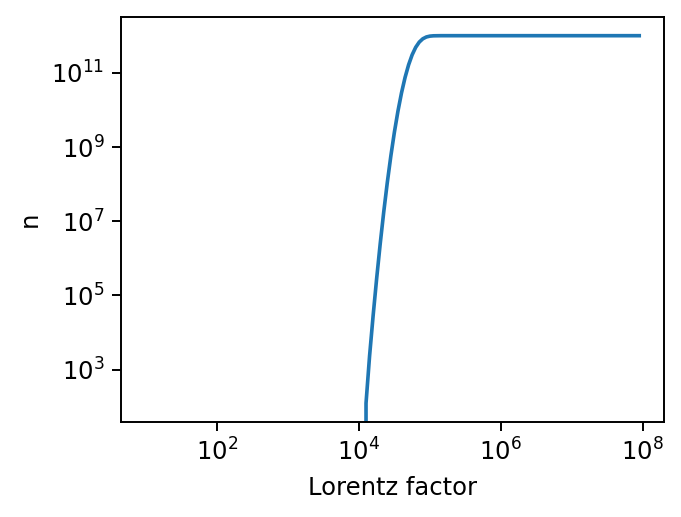

In [ ]:
run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\log_step_simulation_data.csv",
header=None,
low_memory=False,
)
plt.figure(figsize=[4,3])
run_data=run_data.T
run_data.columns = run_data.iloc[0]
run_data = run_data[1:]
run_data.reset_index(drop=True, inplace=True)
plt.plot(run_data["gamma"], run_data.iloc[:,-1])
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-28)
#plt.xlim(1e1, 1e5)
plt.xlabel("Lorentz factor")

# STEADY STATE

Text(0.5, 0, 'Lorentz factor')

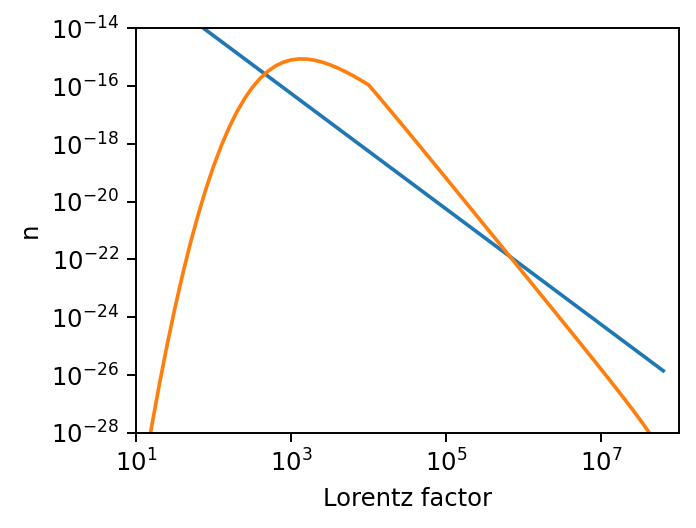

In [ ]:
# Set display options for precision
pd.set_option('display.float_format', '{:.10e}'.format)

# Example code
plt.figure(figsize=[4, 3])
run_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\B1000.csv")

#print(sim_data.to_string())
plt.plot(run_data["gamma"], run_data["0"])
plt.plot(run_data["gamma"], run_data.iloc[:,2])
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-28, 1e-14)
plt.xlim(1e1, 1e8)
plt.xlabel("Lorentz factor")

B = 0.1
B = 0.25
B = 0.5
B = 1.0
B = 1.5
B = 2.0


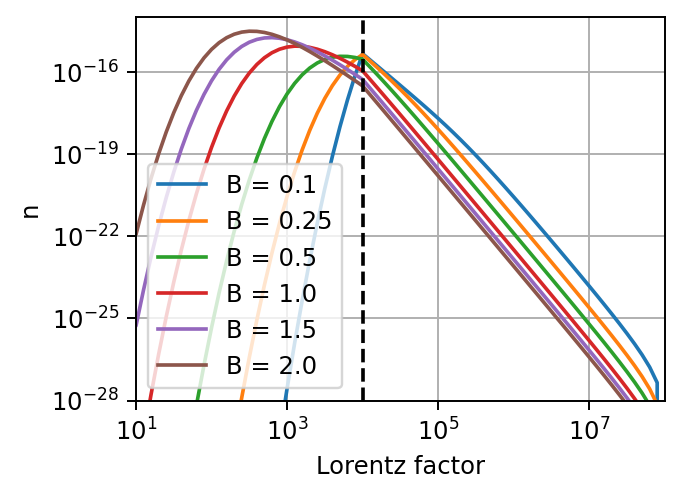

In [ ]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    plt.plot(run_data["gamma"], run_data.iloc[:,2], label=name)
    print(name)
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Lorentz factor")
plt.xlim(1e1,1e8)
plt.ylim(1e-28,1e-14)
plt.vlines(1e4, 1e-28, 1e-7, "black", "dashed")
plt.legend()
plt.tight_layout()
plt.grid()

B = 0.1
B = 0.25
B = 0.5
B = 1.0
B = 1.5
B = 2.0


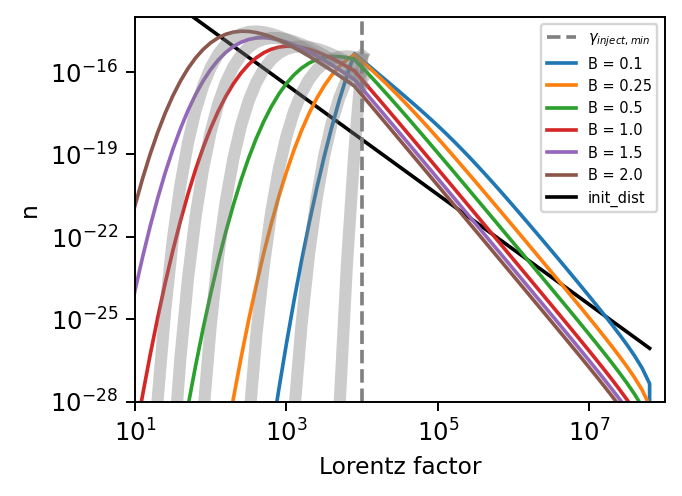

In [ ]:
# Example usage with optional fontsize
files = ["B 100.csv", "B 250.csv", "B 500.csv", 
         "B1000.csv", "B1500.csv", "B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
plot_with_fit(files, names, fontsize=12, plot_initial=True,x_range=[1e1, 1e8], 
              folder="csv_data\steady_state", lnn_bool=False)

# PHOTON POPULATION

In [ ]:
# Example code

run_data = pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\simulation_data.csv")

fig, ax = plt.subplots(2, 1, figsize = (4, 6))

# plot the electron population
ax[0].loglog(eV_e(run_data["gamma"][1:-1]), run_data["iter final"][1:-1])
ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(5e6, 1e12)
ax[0].set_ylim(1e-32, 1e-12)    

# plot the resulting photon population
ax[1].loglog(eV_p(run_data["photon_freq"][1:-1]), run_data["photon_n"][1:-1])
ax[1].set_xlabel(r"comoving photon energy (eV)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
ax[1].set_xlim(1e-6, 1e4)
ax[1].set_ylim(1e-4, 2e0)
plt.tight_layout()

# show
plt.draw()
plt.show()

NameError: name 'pd' is not defined

KeyError: 'iter 1'

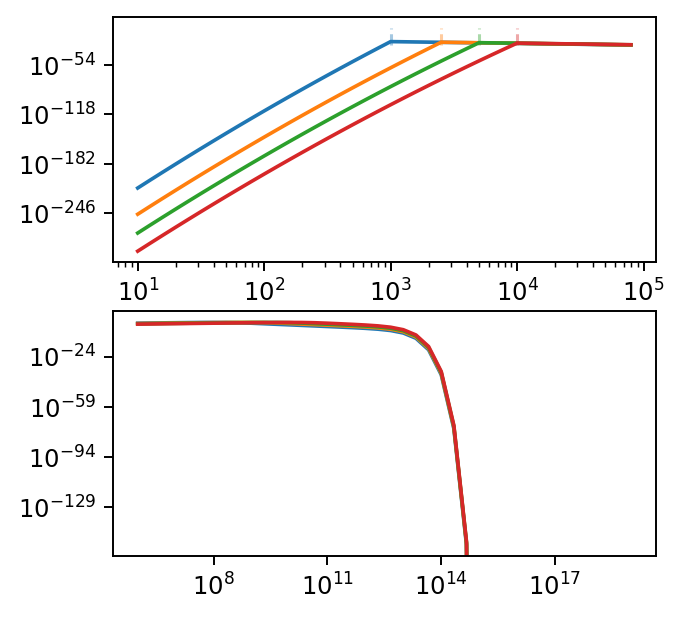

In [ ]:
colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", 
            "tab:brown", "tab:pink","tab:grey", "tab:olive", "tab:cyan"]

mins = [1000,2500,5000,10000,25000,50000]
files = [f"inject_min{minimum}.csv" for minimum in mins]
names = [f"{minimum}" for minimum in mins]

fig, ax = plt.subplots(2, 1, figsize = (4, 4))
for file, name, colour in zip(files,names, colours): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    # plot the electron population
    ax[0].loglog(run_data["gamma"][1:-1], run_data["iter 1"][1:-1], label=name, c=colour)
    ax[0].vlines(run_data["inject_min"][0], 1e-28, 1e-7, colour, "dashed", lw=1.25, alpha=0.4)
    
    # plot the resulting photon population
    ax[1].loglog(run_data["photon_freq"][1:-1], run_data["photon_n"][1:-1], label=name, c=colour)

ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(5e0, 2e9)
ax[0].set_ylim(1e-28, 1e-13)
ax[0].legend(title="$\gamma_{inject}$",loc="upper right", frameon=False, fontsize=6, title_fontsize=6)

ax[1].set_xlabel(r"co-moving frequency $\nu$ (Hz)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
#ax[1].set_xlim(1e5,1e23)
ax[1].set_ylim(1e-12, 10)

plt.tight_layout()
plt.show()

peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    peak_freq.append(run_data["photon_freq"].loc[run_data["photon_n"] == 1].values[0])
    B.append(run_data["inject_min"][0])

plt.plot(B, peak_freq, "rx")

steady_state_spd=B
steady_state_time=peak_freq
# Fit a 4th order polynomial to the data
fit_4th_order(steady_state_spd, steady_state_time)
plt.xlabel("inject min")
#plt.yscale("log")
#plt.xscale("log")
plt.ylabel("peak frequency")
#plt.xlim(1e5, 5e23)
#plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()

        4       3         2
-2.041 x - 1.7 x - 1.403 x - 2.727 x + 12.27


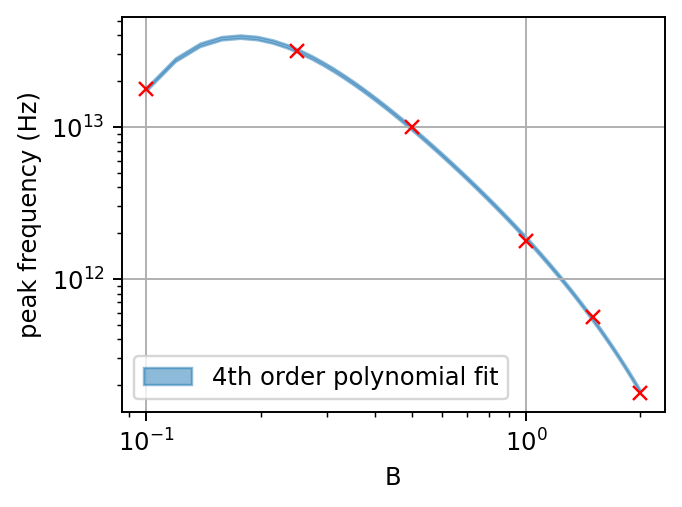

In [ ]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    peak_freq.append(run_data["photon_freq"].loc[run_data["photon_n"] == 1].values[0])
    B.append(run_data["B"][0])

plt.plot(B, peak_freq, "rx")

steady_state_spd=B
steady_state_time=peak_freq
# Fit a 4th order polynomial to the data
fit_4th_order(steady_state_spd, steady_state_time)
plt.xlabel("B")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("peak frequency (Hz)")
#plt.xlim(1e5, 5e23)
#plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()

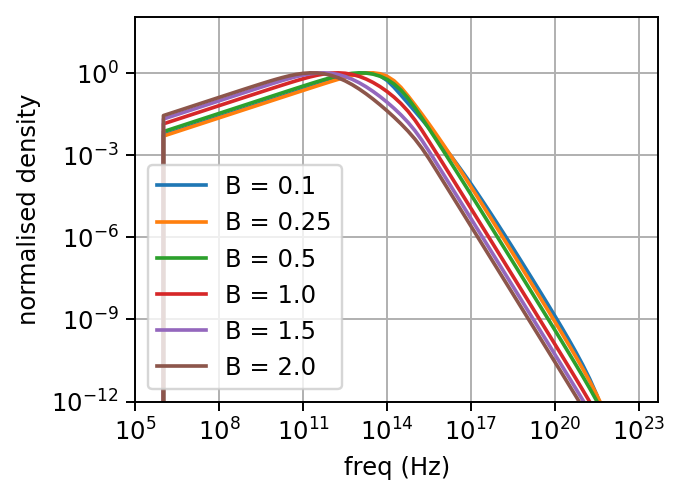

In [ ]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    plt.plot(run_data["photon_freq"], run_data["photon_n"], label = name)
plt.ylabel("normalised density")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("freq (Hz)")
plt.xlim(1e5, 5e23)
plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()

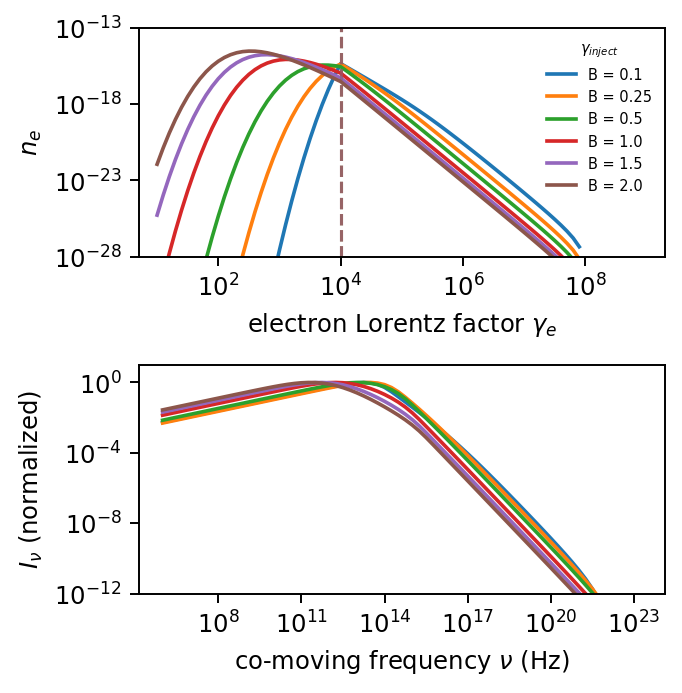

        4       3         2
-2.041 x - 1.7 x - 1.403 x - 2.727 x + 12.27


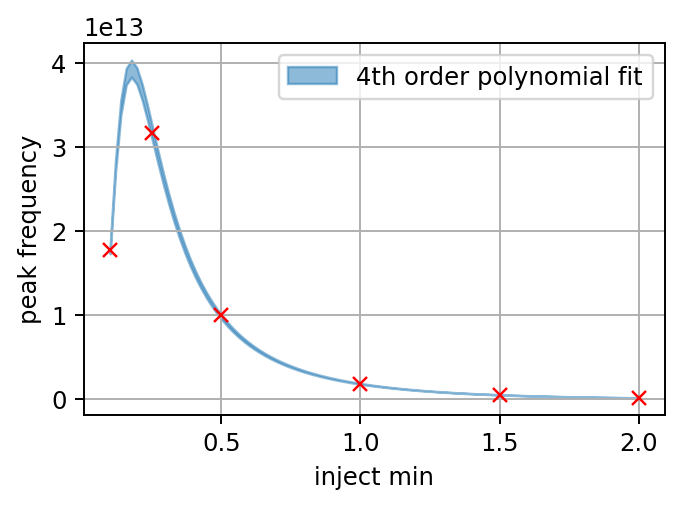

In [ ]:
files = ["B 100.csv","B 250.csv","B 500.csv","B1000.csv","B1500.csv","B2000.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]

fig, ax = plt.subplots(2, 1, figsize = (4, 4))
for file, name, colour in zip(files,names, colours): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    # plot the electron population
    ax[0].loglog(run_data["gamma"][1:-1], run_data["iter 1"][1:-1], label=name, c=colour)
    ax[0].vlines(run_data["inject_min"][0], 1e-28, 1e-7, colour, "dashed", lw=1.25, alpha=0.4)
    
    # plot the resulting photon population
    ax[1].loglog(run_data["photon_freq"][1:-1], run_data["photon_n"][1:-1], label=name, c=colour)

ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$")
ax[0].set_xlim(5e0, 2e9)
ax[0].set_ylim(1e-28, 1e-13)
ax[0].legend(title="$\gamma_{inject}$",loc="upper right", frameon=False, fontsize=6, title_fontsize=6)

ax[1].set_xlabel(r"co-moving frequency $\nu$ (Hz)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
#ax[1].set_xlim(1e5,1e23)
ax[1].set_ylim(1e-12, 10)

plt.tight_layout()
plt.show()

peak_freq = []
B = []
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file))
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\runs\run_{}".format(file))
    peak_freq.append(run_data["photon_freq"].loc[run_data["photon_n"] == 1].values[0])
    B.append(run_data["B"][0])

plt.plot(B, peak_freq, "rx")

steady_state_spd=B
steady_state_time=peak_freq
# Fit a 4th order polynomial to the data
fit_4th_order(steady_state_spd, steady_state_time)
plt.xlabel("inject min")
#plt.yscale("log")
#plt.xscale("log")
plt.ylabel("peak frequency")
#plt.xlim(1e5, 5e23)
#plt.ylim(1e-12,None)
plt.legend()
plt.tight_layout()
plt.grid()